In [ ]:
# 사용할 수 있는 라이브러리
import pandas
import matplotlib
import scipy
import seaborn
import scikit-learn
import numexpr
import scikit-image
import sympy
import cython
import pasty
import statsmodel
import cloudpickle
import dill
import numba
import bokeh
import sqlalchemy
import hdf5
import vincent
import beautifulsoup
import protobuf
import xlrd package

# 약품 처방 금액 예측

### Data

* 이 문제에 사용되는 데이터는 실제 국민건강보험의 처방내역을 바탕으로 합니다.
* 처방번호, 약품코드, 가입자번호는 원본을 유추할 수 없도록 전처리되어있습니다.
* 같이 처방된 약품은 처방 번호가 같은 개별 행으로 구분되어 주어집니다.
    * 예를 들어 감기약, 해열제, 진해거담제, 위장약을 함께 처방받았다면 처방번호가 같은 row가 4개 생깁니다.
    
##### train.csv

* 처방번호: 약의 처방 번호 입니다. 특정 지을 수 없도록 익명화되어 있습니다.
* 약품코드: 개별 약품의 코드를 의미합니다. 약품을 특정 지을 수 없도록 익명화되어 있습니다.
* 일련번호: 처방번호가 같은 처방에서의 일련번호 입니다. 같은 약품이 용량 등의 이유로 중복 처방되기도 하는데 이 값으로 구분합니다.
* 가입자번호: 처방받은 사람의 국민건강보험 가입자번호로 익명화 되어 있습니다.
* 성별코드: 1 = 남자, 2 = 여자를 의미합니다.
* 연령대코드(5세단위): 5세 단위의 연령대코드 입니다.
* 시도코드: 시도 단위 코드로 숫자로 되어 있습니다.
* 요양개시일자: 요양개시일자로 연월일로 되어 있습니다.
* 1회 투약량
* 1일투약량
* 총투여일수
* 금액: 처방내역에 따른 금액입니다.

##### test.csv

* id 컬럼이 있으며, 금액 컬럼이 없습니다. 
* 그 외에는 train.csv에 있는 모든 컬럼이 동일하게 있습니다.

### 초기 코드 선택

Python, R 중 본인의 선호 언어에 따라 초기 코드를 선택하세요. Python을 선호한다면 Python 초기 코드를, R을 선호한다면 R 초기 코드만 남기면 됩니다. 언어를 변경하는 방법이나 사용할 수 있는 라이브러리는 상단의 도움말 버튼에 나와있습니다.

In [80]:
# 초기코드 - python
import pandas as pd

# 데이터 로드
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv', index_col='id')

print(len(train))
train.head()

11951


,처방번호,약품코드,일련번호,가입자번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,1회 투약량,1일투약량,총투여일수,금액
0,0,0,7,0,1,17,41,20160102,1.0,1,30,2310
1,0,1,2,0,1,17,41,20160102,1.0,1,30,2100
2,0,2,1,0,1,17,41,20160102,1.0,1,30,5550
3,0,3,3,0,1,17,41,20160102,1.0,1,30,11880
4,0,4,6,0,1,17,41,20160102,1.0,1,30,73800


# 문제

train 데이터를 활용해 test 데이터의 처방 금액을 예측하는 것이 이번 과제의 목표입니다.

### 할 일

train.csv 처방정보의 금액 정보를 바탕으로 나머지 test.csv 데이터의 처방 금액을 예측해 주세요.

| id | 금액 |
|----|------|
| 0  | 0    |
| 1  | 0    |
| 2  | 0    |
| 3  | 0    |
| 4  | 0    |

<br/>
<center><예측 결과 예시></center>

*주의* 

1. 보편적인 분석 과정에 입각하여 **데이터 전처리 - EDA - 피처 엔지니어링 - 모델링 - 평가** 순으로 코드를 작성해주세요. 
    * 작성하신 코드와 주석은 정성 평가 시 참고 자료로 활용됩니다.
2. 예측 결과를 재현할 수 있도록 random seed 값을 고정시켜주세요.
3. 면접관이 코드를 이해할 수 있도록 적절한 주석이나, 마크다운으로 설명을 작성해주세요.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [81]:
train=train.rename(columns={
    '처방번호':'rxnum','약품코드':'drugcode','일련번호':'serialnum','가입자번호':'clientnum',
    '성별코드':'sex','연령대코드(5세단위)':'age', '시도코드':'area','요양개시일자':'startdate',
    '1회 투약량':'onedose','1일투약량':'dailydose','총투여일수':'period','금액':'price'})
train.head()

,rxnum,drugcode,serialnum,clientnum,sex,age,area,startdate,onedose,dailydose,period,price
0,0,0,7,0,1,17,41,20160102,1.0,1,30,2310
1,0,1,2,0,1,17,41,20160102,1.0,1,30,2100
2,0,2,1,0,1,17,41,20160102,1.0,1,30,5550
3,0,3,3,0,1,17,41,20160102,1.0,1,30,11880
4,0,4,6,0,1,17,41,20160102,1.0,1,30,73800


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11951 entries, 0 to 11950
Data columns (total 12 columns):
rxnum        11951 non-null int64
drugcode     11951 non-null int64
serialnum    11951 non-null int64
clientnum    11951 non-null int64
sex          11951 non-null int64
age          11951 non-null int64
area         11951 non-null int64
startdate    11951 non-null int64
onedose      11951 non-null float64
dailydose    11951 non-null int64
period       11951 non-null int64
price        11951 non-null int64
dtypes: float64(1), int64(11)
memory usage: 1.1 MB


In [83]:
# 데이터 타입
# 범주형 변수들의 타입을 object로 변환한다.
train['rxnum'] = train['rxnum'].astype(object)
train['drugcode'] = train['drugcode'].astype(object)
train['serialnum'] = train['serialnum'].astype(object)
train['clientnum'] = train['clientnum'].astype(object)
train['sex'] = train['sex'].astype(object)
train['area'] = train['area'].astype(object)
train['startdate'] = train['startdate'].astype(object)

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11951 entries, 0 to 11950
Data columns (total 12 columns):
rxnum        11951 non-null object
drugcode     11951 non-null object
serialnum    11951 non-null object
clientnum    11951 non-null object
sex          11951 non-null object
age          11951 non-null int64
area         11951 non-null object
startdate    11951 non-null object
onedose      11951 non-null float64
dailydose    11951 non-null int64
period       11951 non-null int64
price        11951 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 1.1+ MB


In [65]:
# ----------- data 전처리 시작
# Null data 체크
train.isnull().sum()

rxnum        0
drugcode     0
serialnum    0
clientnum    0
sex          0
age          0
area         0
startdate    0
onedose      0
dailydose    0
period       0
price        0
unitprice    0
dtype: int64

# 범주형 변수 분포 확인

In [66]:
# 범주형 변수
category_features_2 = [col for col in train.columns if train[col].dtypes == "object"]
category_features_2

['rxnum',
 'drugcode',
 'serialnum',
 'clientnum',
 'sex',
 'age',
 'area',
 'startdate']

In [76]:
category_features = ['sex', 'area']

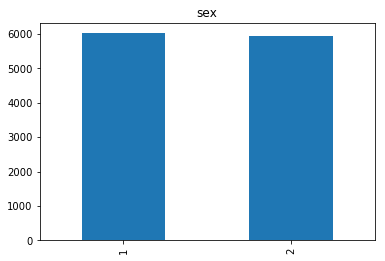

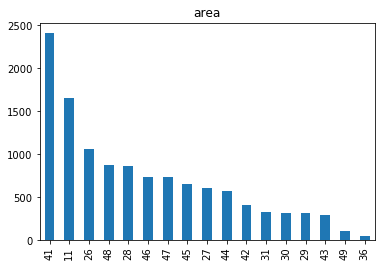

In [77]:
for col in category_features:
    train[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

# 수치형 변수 분포 확인

In [78]:
numerical_features = ['onedose','dailydose','period', 'age']

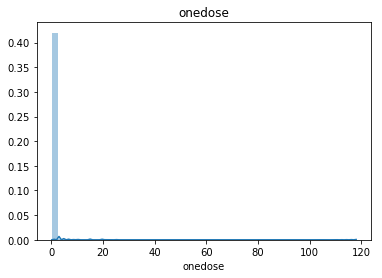

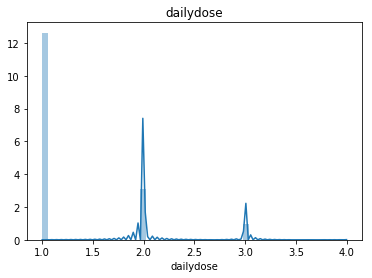

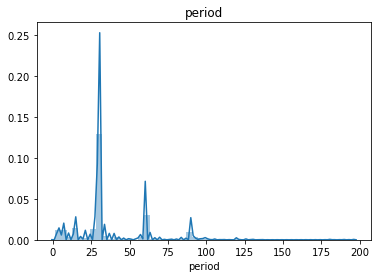

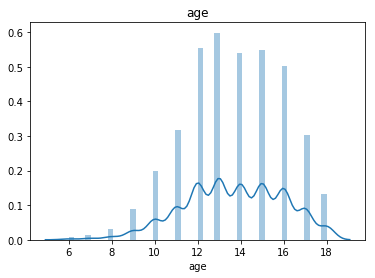

In [85]:
for col in numerical_features:
    sns.distplot(train.loc[train[col].notnull(), col])
    plt.title(col)
    plt.show()

# 단위금액 계산
1회 투약량 계산. 처방번호 같고 약품코드 같은데 일련번호 다를 때. 계산해야하나?

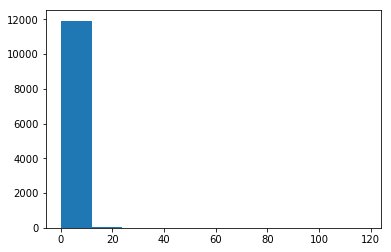

In [87]:
plt.hist(train['onedose'])
plt.show()

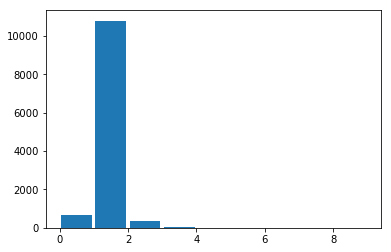

In [88]:
plt.hist(train['onedose'], range(0,10), rwidth=0.9)
plt.show()

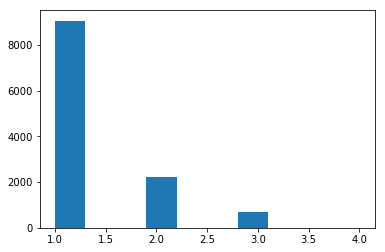

In [89]:
plt.hist(train['dailydose'])
plt.show()

In [90]:
train['unitprice'] = train['price']/train['onedose']/train['dailydose']/train['period']
train.head()

,rxnum,drugcode,serialnum,clientnum,sex,age,area,startdate,onedose,dailydose,period,price,unitprice
0,0,0,7,0,1,17,41,20160102,1.0,1,30,2310,77.0
1,0,1,2,0,1,17,41,20160102,1.0,1,30,2100,70.0
2,0,2,1,0,1,17,41,20160102,1.0,1,30,5550,185.0
3,0,3,3,0,1,17,41,20160102,1.0,1,30,11880,396.0
4,0,4,6,0,1,17,41,20160102,1.0,1,30,73800,2460.0


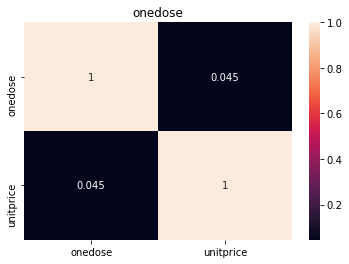

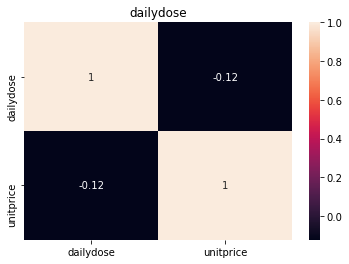

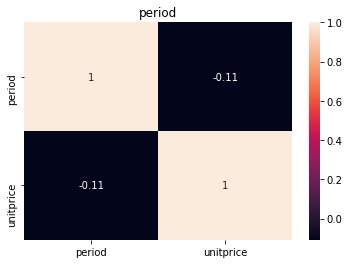

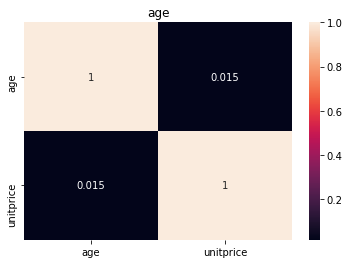

In [91]:
# 사전 상관분석
for col in numerical_features:
    Var_Corr = train[[col,'unitprice']].corr()
    sns.heatmap(Var_Corr, annot=True)
    plt.title(col)
    plt.show()

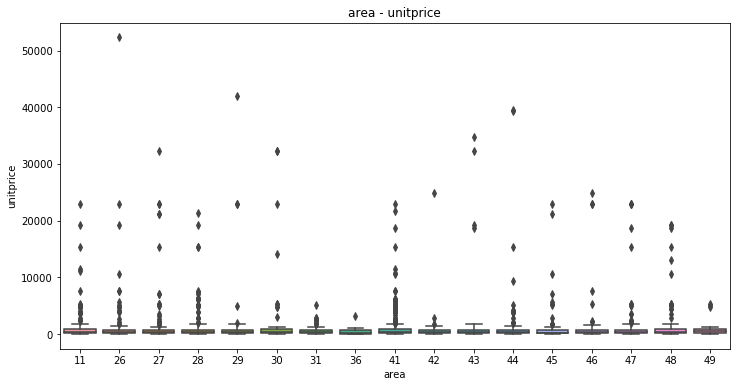

In [62]:
#unique_list = train['age'].unique()
 
plt.figure(figsize=(12,6))
sns.boxplot(x='area', y='unitprice', data=train)
plt.title("area - {}".format('unitprice'))
plt.show()

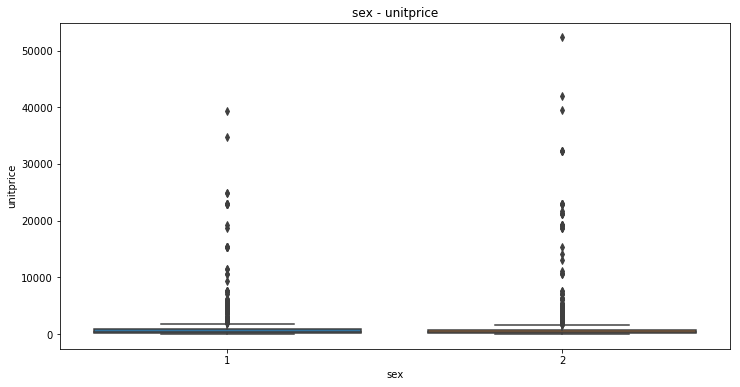

In [94]:
#unique_list = train['age'].unique()
 
plt.figure(figsize=(12,6))
sns.boxplot(x='sex', y='unitprice', data=train)
plt.title("sex - {}".format('unitprice'))
plt.show()

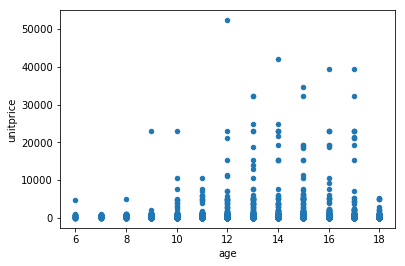

In [112]:
train.plot.scatter(x='age',y='unitprice')

In [115]:
# 회귀분석
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [116]:
result = sm.ols(formula = 'unitprice ~ sex + age + area', data = train).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              unitprice   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.590
Date:                Sat, 25 Apr 2020   Prob (F-statistic):             0.0535
Time:                        11:55:03   Log-Likelihood:            -1.0563e+05
No. Observations:               11951   AIC:                         2.113e+05
Df Residuals:                   11932   BIC:                         2.114e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    384.7610     99.350      3.873      0.000     190.020     579.502
sex[T.2]      26.0679     31.306      0.833      0.405     -35.297      87.433
area[T.26]    15.8267     65.868      0.240      0.810    -113.286     144.939
area[T.27]   150.7312     79.623      1.893      0.058      -5.342     306.804
area[T.28]    52.0127     70.148      0.741      0.458     -85.489     189.514
area[T.29]   176.1633    103.037      1.710      0.087     -25.806     378.133
area[T.30]   293.6065    102.980      2.851      0.004      91.748     495.465
area[T.31]   -87.7644    100.848     -0.870      0.384    -285.443     109.914
area[T.36]  -134.4132    235.211     -0.571      0.568    -595.465     326.639
area[T.41]     2.5934     53.405      0.049      0.961    -102.090     107.277
area[T.42]   -47.2196     92.432     -0.511      0.609    -228.401     133.962
area[T.43]   246.8546    106.489      2.318      0.020      38.119     455.591
area[T.44]   105.9114     80.834      1.310      0.190     -52.537     264.359
area[T.45]   -36.6611     77.469     -0.473      0.636    -188.514     115.191
area[T.46]     5.2014     74.018      0.070      0.944    -139.886     150.289
area[T.47]    49.8923     74.176      0.673      0.501     -95.504     195.288
area[T.48]    61.7385     69.969      0.882      0.378     -75.413     198.890
area[T.49]    42.6646    168.277      0.254      0.800    -287.185     372.515
age           10.8020      6.798      1.589      0.112      -2.524      24.128
==============================================================================
Omnibus:                    22831.029   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40737983.898
Skew:                          14.950   Prob(JB):                         0.00
Kurtosis:                     287.457   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
#다중선형회귀분석
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(train[['area','sex','age']], train[['unitprice']]) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [ ]:
test

##### 2. 예측 결과 저장

채점을 위해 위에서 예측한 데이터를 현재 파일과 같은 디렉토리(.ipynb 파일이 있는 디렉토리)에 `submission.csv`라는 이름으로 저장해주세요. 저장할 파일 포맷은 다음 표와 data 디렉토리의 `submission(sample).csv` 파일을 참고하세요.


| id | 금액 |
|----|------|
| 0  | 0    |
| 1  | 0    |
| 2  | 0    |
| 3  | 0    |
| 4  | 0    |

<br/>
<center><파일 저장 예시></center>

*주의* 

1. csv 파일의 컬럼은 반드시 id-금액 순이어야 합니다.
2. id는 오름차 순으로 정렬되어있어야 합니다.

### 여기에 코드를 작성하세요.

In [ ]:
# csv 파일 저장 예시 - python
test.to_csv('submission.csv')

In [ ]:
# csv 파일 저장 예시 - R
write.csv(test, file='submission.csv')